In [4]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob as gb
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import random
import pickle
import pandas as pd

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
data_dir="/content/drive/MyDrive/photos"

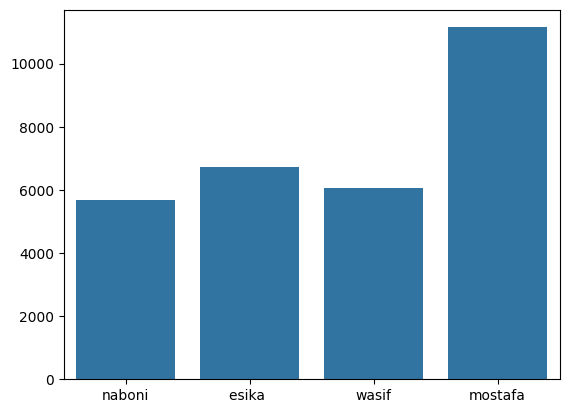

In [7]:
IMG_SIZE=128
BATCH_SIZE=16
categories = []
class_count = []

train_example = 0
for f in os.listdir(data_dir):
    files = gb.glob(str(data_dir + '//' + f + '/*.[jJ][pP][eE][gG]')) + \
        gb.glob(str(data_dir + '//' + f + '/*.[jJ][pP][gG]')) + \
        gb.glob(str(data_dir + '//' + f + '/*.[pP][nN][gG]')) + \
        gb.glob(str(data_dir + '//' + f + '/*.[hH][eE][iI][cC]'))

    categories.append(f)
    class_count.append(len(files))
    train_example += len(files)

sns.barplot(x=categories, y=class_count)
plt.show()

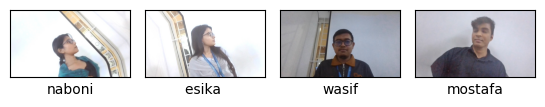

In [8]:
plt.figure(figsize=(15,4))
i=0
for c in categories:
    path = os.path.join(data_dir,c)
    try:
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img))
            plt.subplot(3,11,i+1)
            plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
            plt.xlabel(c)
            plt.xticks([])
            plt.yticks([])
            i += 1
            break
    except Exception as e:
        pass
plt.tight_layout()
plt.show()

In [9]:
train_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)
train_batches = train_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'
)
valid_batches = train_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)

Found 23695 images belonging to 4 classes.
Found 5921 images belonging to 4 classes.


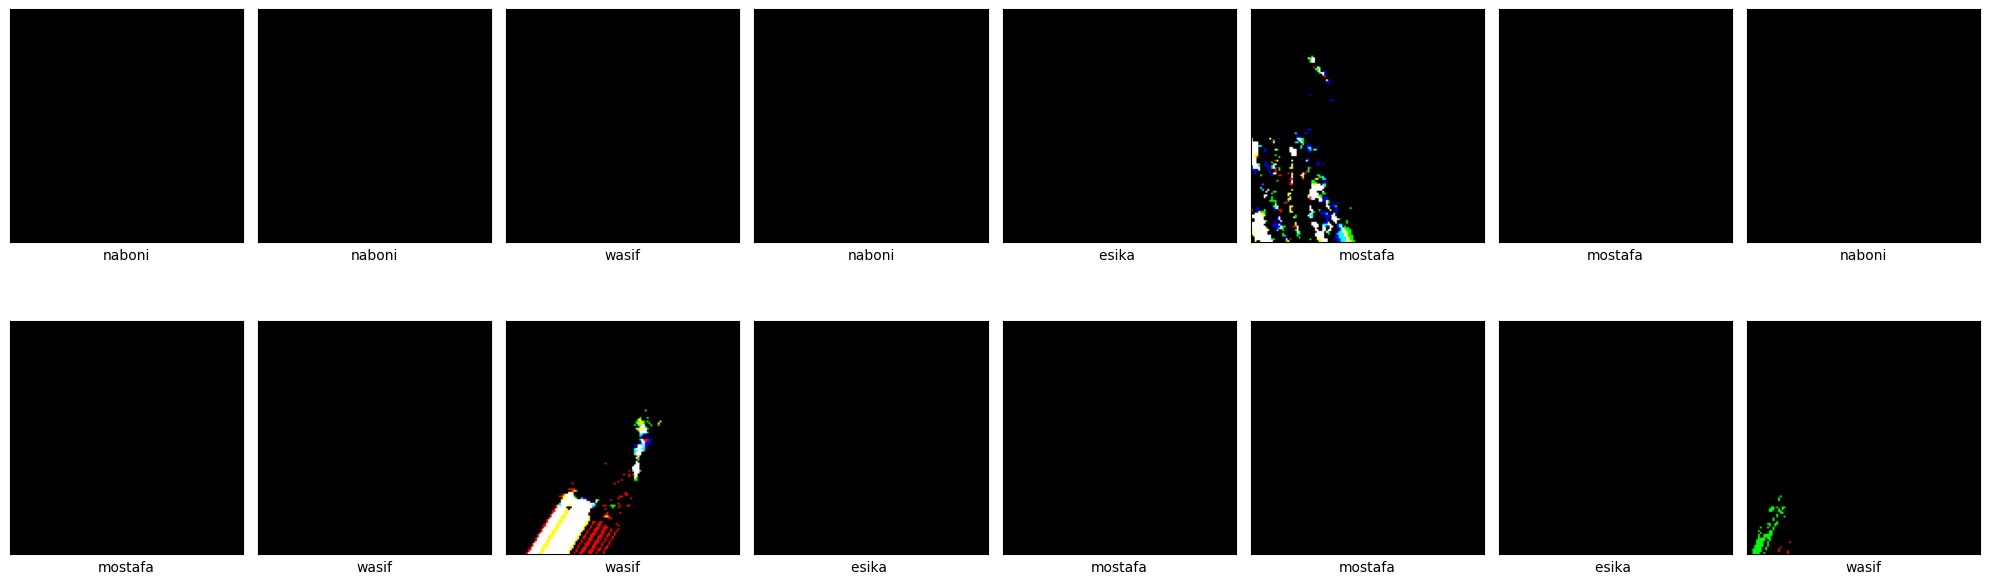

In [10]:
imgs, labels = next(train_batches)
i = 0
plt.figure(figsize=(20,7))
for img, label in zip(imgs, labels):
    plt.subplot(2,8,i+1)
    plt.imshow(img.astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(categories[label.astype('int32')])
    i+=1
    if i == 30:
        break
plt.tight_layout()
plt.show()

In [11]:
imput_shape = (IMG_SIZE, IMG_SIZE)+(3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=imput_shape,
    include_top=False,
    weights='imagenet'
)
base_model.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [12]:
input = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x = base_model(input,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)
x = tf.keras.layers.Dense(256,activation='relu')(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
output = tf.keras.layers.Dense(len(categories),activation='softmax')(x)
model = tf.keras.Model(input,output)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,078,596 (11.74 MB)

 Trainable params: 3,044,484 (11.61 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [14]:
h = model.fit(
    train_batches,steps_per_epoch=344//BATCH_SIZE,
    epochs=10,
    validation_data=valid_batches,
    validation_steps=72//BATCH_SIZE,

)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 206s 8s/step - accuracy: 0.4164 - loss: 1.2302 - val_accuracy: 0.7344 - val_loss: 0.7148
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 140s 7s/step - accuracy: 0.8644 - loss: 0.4808 - val_accuracy: 0.7188 - val_loss: 0.4229
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 144s 7s/step - accuracy: 0.9677 - loss: 0.1586 - val_accuracy: 0.9062 - val_loss: 0.2290
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - accuracy: 0.9653 - loss: 0.1160 - val_accuracy: 0.7656 - val_loss: 0.4984
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - accuracy: 0.9925 - loss: 0.0344 - val_accuracy: 0.7656 - val_loss: 0.5912
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 144s 7s/step - accuracy: 0.9825 - loss: 0.0538 - val_accuracy: 0.7812 - val_loss: 0.5235
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.9884 - loss: 0.0450 - val_accuracy: 0.8594 - val_loss: 0.2785
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.9770 - loss: 0.0755 - val_accuracy: 0.8906 - val_

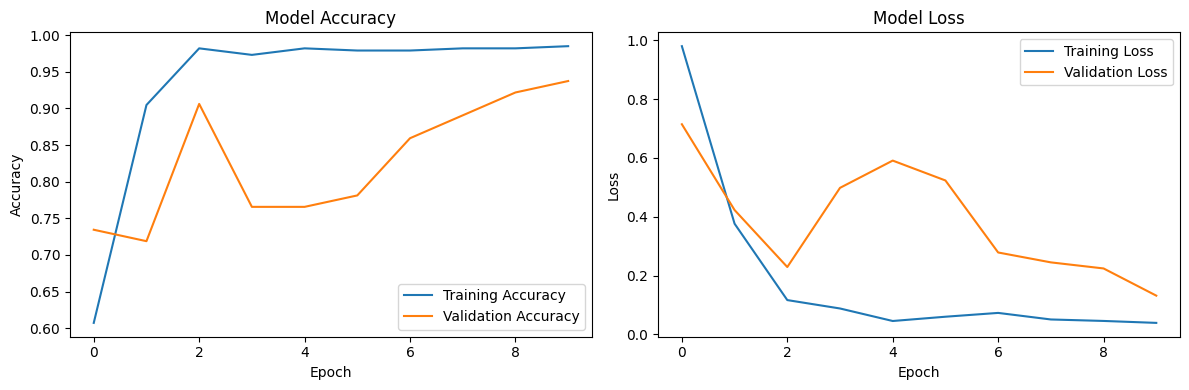

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['accuracy'], label='Training Accuracy')
plt.plot(h.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(h.history['loss'], label='Training Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [16]:
model.save('/content/drive/MyDrive/photos.h5')

In [17]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob as gb
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import random
import pandas as pd
from tensorflow.keras.models import load_model
from keras.preprocessing.image import img_to_array

In [18]:
model = load_model('/content/drive/MyDrive/photos.h5')

In [19]:
Data_Path='/content/drive/MyDrive/photos'
classes = os.listdir(Data_Path)
print("class_names :", classes)

class_names : ['naboni', 'esika ', 'wasif', 'mostafa']


In [20]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

def js_to_image(js_reply):
  image_bytes = b64decode(js_reply.split(',')[1])
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

def bbox_to_bytes(bbox_array):

  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  bbox_PIL.save(iobuf, format='png')
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640;
      captureCanvas.height = 480;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [23]:
import pandas as pd
from datetime import datetime as DT

def create_Excel(filename='/content/drive/MyDrive/photos.xlsx', student_names=[]):
    current_date = DT.now().strftime('%Y-%m-%d')
    data = {
        "Name": student_names,
        current_date: [0] * len(student_names)
    }
    df = pd.DataFrame(data)
    try:
        df.to_excel(filename, index=False)
        print(f"Excel file '{filename}' created successfully!")
    except Exception as e:
        print(f"Error occurred while creating the Excel file '{filename}': {e}")

def update_attend(filename, student_name):
    current_date = DT.now().strftime('%Y-%m-%d')

    try:
        df = pd.read_excel(filename)

        if student_name in df['Name'].values:
            index = df.index[df['Name'] == student_name][0]
            attendance = df.at[index, current_date]

            if attendance == 1:
                print(f"{student_name} has already attended.")
            else:
                df.at[index, current_date] = 1
                print(f"{student_name}'s attendance marked as 1.")
        else:
            print(f"Student '{student_name}' doesn't exist in the records.")

        df.to_excel(filename, index=False)
    except Exception as e:
        print(f"Error occurred while updating the Excel file '{filename}': {e}")

video_stream()

label_html = 'Capturing...'

bbox = ''
count = 0

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    img = js_to_image(js_reply["img"])

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        face_roi = gray[y:y+h, x:x+w]

        resized_face = cv2.resize(face_roi, (128, 128))

        normalized_face = resized_face / 255.0

        input_image_batch = np.expand_dims(normalized_face, axis=0)

        input_image_batch = np.repeat(input_image_batch, 3, axis=-1)

        input_image_batch = input_image_batch.reshape(-1, 128, 128, 3)

        predictions = model.predict(input_image_batch)
        predicted_class = np.argmax(predictions)
        predicted_class_name = classes[predicted_class]
        print("Predicted class:", predicted_class_name)

        update_attend('/content/drive/MyDrive/photos.xlsx', predicted_class_name)

        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

        text = f'Predicted Class Name: {predicted_class_name}'
        cv2.putText(img, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        frame_bytes = cv2.imencode('.jpg', img)[1].tobytes()



<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Predicted class: esika 
esika  has already attended.


In [24]:
create_Excel('/content/drive/MyDrive/photos.xlsx', classes)

Excel file '/content/drive/MyDrive/photos.xlsx' created successfully!
